# Reading the ROOT files

In [156]:
import keras_tuner as kt

ModuleNotFoundError: No module named 'tensorboard.plugins.hparams'

In [ ]:
kt.Hyperband()

In [1]:
# %matplotlib notebookimport uproot
import numpy as np
import pandas as pd
import awkward as ak
from scipy.stats import norm
import scipy.interpolate as interpolate
from scipy.ndimage import median as med

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Input, InputLayer
from tensorflow.keras.layers import Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
import keras_tuner as kt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [41]:
import tensorflow.keras.backend as K
import tensorflow as tf
def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

In [102]:
from tensorflow.keras import callbacks

In [80]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Input, InputLayer
from keras.preprocessing import sequence
# from keras.preprocessing import to_categorical

In [45]:
import uproot
import numpy as np
import pandas as pd

In [46]:
import matplotlib.pyplot as plt
import awkward as ak
from mpl_toolkits.mplot3d import axes3d 
from matplotlib.colors import LogNorm
import IPython
from sklearn import metrics

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [48]:
from scipy.stats import norm
import scipy.interpolate as interpolate
from scipy.ndimage import median as med

In [49]:
from keras.layers import Concatenate, Flatten
from keras.models import Model


In [50]:
pmtpos = np.loadtxt('pmtpositions.csv', delimiter=',')
pmtpos = np.vstack((np.array([0, 0, 0]), pmtpos))

In [150]:
ak.to_json(fastn, 'fastn.json')

In [51]:
fastn = uproot.open('data/fastn.root'+':data')
ibd = uproot.open('data/ibd.root'+':data')
fastn = fastn.arrays(library='awkward')
ibd = ibd.arrays(library='awkward')

In [52]:
# Time-sort all the data arrays for recurrent/sequential purposes. 
for j, data in enumerate([fastn, ibd]):
#     data['restime'] = data['hittime']
    print('set %i'%(j))
    args = ak.argsort(data['hittime'])
    for key in ['hittime', 'pmtcharge', 'channel']:
        data[key] = data[key][args]

set 0
set 1


Separate out prompt/delayed IBD and delta-ray/neutron capture fast-neutrons

In [53]:
# Get rid of the first and last events of each run 
ibd = ibd[ibd['inner_hit_prev']>0]
ibd = ibd[ibd['inner_hit_next']>0]
ibd = ibd[ibd['dt_prev_us']>0]
fastn = fastn[fastn['inner_hit_prev']>0]
fastn = fastn[fastn['inner_hit_next']>0]
fastn = fastn[fastn['dt_prev_us']>0]

Make sure all times that are larger than ~600 us are set to some constant, e.g. 500 us. 
<br>
This is because the rates are arbitrary in the case of us using these samples -- these are just injected rates. 

In [54]:
dims = ak.fields(data)
prev_vars = [i for i in dims if 'prev' in i.lower()]
post_vars = [i for i in dims if 'next' in i.lower()]
proxvars = np.append(prev_vars, post_vars)

In [55]:
prev_vars_replace = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
                     1e4, 1e4, 1e4, 1e4, 600, 
                     0, 0, 0, 0, 0, 0]
post_vars_replace = [0, 0, 0, 0, 0, 0, 0, 0, 0, 
                     1e4, 1e4, 1e4, 1e4, 600]
                     

In [56]:
def calcr(data):
    data['r'] = np.sqrt(data['x']**2+data['y']**2)
    return data

In [57]:
#do we need to also remove the distance information? 
for data in [fastn, ibd]:
    data = calcr(data)
    for t, varbls, replace in zip(['dt_prev_us', 'dt_next_us'], [prev_vars, post_vars], 
                        [prev_vars_replace, post_vars_replace]):
        prox_mask = data[t]<600
        for k, key in enumerate(varbls): 
            data[key] = ak.where(prox_mask, data[key], replace[k])

In [58]:
dimensions = [
    'n9', 'n9_prev', 'n9_next',
    'x', 'y', 'z',  'r',
    'id_plus_dr_hit', 'inner_hit_prev', 'inner_hit_next',
    'good_dir', 'good_dir_prev', 'good_dir_next',
    'good_pos','good_pos_prev', 'good_pos_next',
#     'distpmt', 
    'closestPMT', 'closestPMT_prev', 'closestPMT_next', 
    'drPrevr', 'dzPrevz', 'drNextr', 'dzNextz',
     'dt_prev_us', 'dt_next_us',
    'azimuth_ks', 'azimuth_ks_prev','azimuth_ks_next',
    'n100', 'pe', 
    'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
    'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(len(dimensions)))
    return df_cut

## Data Prep

In [66]:
delaytime = 1e5
c = 21.8 #cm/ns

for j, data in enumerate([ibd, fastn]):
    channels = []
    charges = []
    timess = []
    chn = data['channel']    
    print('set %i of %i'%(j+1, 3))
    times = data['hittime']-800.
    for i, ht in enumerate(data['hittime']): 
        if i%10_000==0:
            print('-----Processing sample %i of %i-----'%(i, len(data)))
        xyz = pmtpos[chn[i]] #cm
        vertex = [data['x'][i]/10., data['y'][i]/10., data['z'][i]/10.] #cm
        dist = np.sqrt(np.sum((xyz - vertex)**2, axis=1)) # cm
        res = times[i] - dist/c
        promptmask = np.logical_and(res<delaytime, res>-1*delaytime)
        channels.append(data['channel'][i][promptmask])
        charges.append(data['pmtcharge'][i][promptmask])
        timess.append(res[promptmask])
    data['restime'] = ak.Array(timess)
    data['promptchan'], data['promptcharge'], data['prompttime'] = ak.Array(channels), ak.Array(charges), ak.Array(timess)

set 1 of 3
-----Processing sample 0 of 36834-----
-----Processing sample 10000 of 36834-----
-----Processing sample 20000 of 36834-----
-----Processing sample 30000 of 36834-----
set 2 of 3
-----Processing sample 0 of 25469-----
-----Processing sample 10000 of 25469-----
-----Processing sample 20000 of 25469-----


------

In [67]:
def prep_net_data(data_to_manipulate, 
                  prompt=True, restime=True,
                  maxlen=100):
    X = []
    y = np.array([])
    
    if prompt==True:
        keys = ['promptchan', 'promptcharge', 'prompttime']
    elif prompt==False:
        keys = ['channel', 'pmtcharge', 'hittime']
    if restime==True:
        keys.append('restime')
        
    diminput = len(keys)
    for d, dat in enumerate(data_to_manipulate):
        print('Running set %i of %i'%(d+1, len(data_to_manipulate)))
        new = np.empty(shape=(len(dat), maxlen, diminput+2))

        chn = sequence.pad_sequences(dat[keys[0]]+1, maxlen=maxlen, 
                                     padding='post', 
                                     dtype='int32')
        chrg = sequence.pad_sequences(dat[keys[1]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        
        xyz = pmtpos[chn]+1 #since value of 0 has meaning..
        
        time = sequence.pad_sequences(dat[keys[2]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        new[:,:,0] = chrg
        new[:,:,1] = time    
        new[:,:,2:5] = xyz+1
        
        if restime==True:
            res_times = sequence.pad_sequences(dat[keys[3]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
            new[:,:,5] = res_times
            
        if len(X)>0:
            X = np.append(X, new, axis=0)
        else: 
            X = new
        y=np.append(y, d*np.ones(len(new)))    
    return X, y

Add in residual time and pmt info (can cut for promptness in mask if wanted. Now not doing.) 

In [30]:
delaytime = 1e5
c = 21.8 #cm/ns

for j, data in enumerate([ibd, fastn]):
    channels = []
    charges = []
    timess = []
    chn = data['channel']    
    print('set %i of %i'%(j+1, 3))
    times = data['hittime']-800.
    for i, ht in enumerate(data['hittime']): 
        if i%10_000==0:
            print('-----Processing sample %i of %i-----'%(i, len(data)))
        xyz = pmtpos[chn[i]] #cm
        vertex = [data['x'][i]/10., data['y'][i]/10., data['z'][i]/10.] #cm
        dist = np.sqrt(np.sum((xyz - vertex)**2, axis=1)) # cm
        res = times[i] - dist/c
        promptmask = np.logical_and(res<delaytime, res>-1*delaytime)
        channels.append(data['channel'][i][promptmask])
        charges.append(data['pmtcharge'][i][promptmask])
        timess.append(res[promptmask])
    data['restime'] = ak.Array(timess)
    data['promptchan'], data['promptcharge'], data['prompttime'] = ak.Array(channels), ak.Array(charges), ak.Array(timess)

set 1 of 3
-----Processing sample 0 of 36834-----
-----Processing sample 10000 of 36834-----
-----Processing sample 20000 of 36834-----
-----Processing sample 30000 of 36834-----
set 2 of 3
-----Processing sample 0 of 25469-----
-----Processing sample 10000 of 25469-----
-----Processing sample 20000 of 25469-----


------

In [31]:
def prep_net_data(data_to_manipulate, 
                  prompt=True, restime=True,
                  maxlen=100):
    X = []
    y = np.array([])
    
    if prompt==True:
        keys = ['promptchan', 'promptcharge', 'prompttime']
    elif prompt==False:
        keys = ['channel', 'pmtcharge', 'hittime']
    if restime==True:
        keys.append('restime')
        
    diminput = len(keys)
    for d, dat in enumerate(data_to_manipulate):
        print('Running set %i of %i'%(d+1, len(data_to_manipulate)))
        new = np.empty(shape=(len(dat), maxlen, diminput+2))

        chn = sequence.pad_sequences(dat[keys[0]]+1, maxlen=maxlen, 
                                     padding='post', 
                                     dtype='int32')
        chrg = sequence.pad_sequences(dat[keys[1]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        
        xyz = pmtpos[chn]+1 #since value of 0 has meaning..
        
        time = sequence.pad_sequences(dat[keys[2]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        new[:,:,0] = chrg
        new[:,:,1] = time    
        new[:,:,2:5] = xyz+1
        
        if restime==True:
            res_times = sequence.pad_sequences(dat[keys[3]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
            new[:,:,5] = res_times
            
        if len(X)>0:
            X = np.append(X, new, axis=0)
        else: 
            X = new
        y=np.append(y, d*np.ones(len(new)))    
    return X, y

## Getting data in input form

In [68]:
all_data = ak.concatenate([ibd, fastn])

In [69]:
fn = all_data['code']==2
invbeta = all_data['code']==1
id0 = all_data['subid']==0
id1p = all_data['subid']>0 # >0 changes things 

In [70]:
ibd0_mask = ak.from_iter([all(t) for t in zip(invbeta, id0)])
ibd1_mask = ak.from_iter([all(t) for t in zip(invbeta, id1p)])
fastn0_mask = ak.from_iter([all(t) for t in zip(fn, id0)])
fastn1_mask = ak.from_iter([all(t) for t in zip(fn, id1p)])

In [71]:
samples = min([ak.count_nonzero(fn), 
              ak.count_nonzero(ibd0_mask), 
              ak.count_nonzero(ibd1_mask)])

In [72]:
x1 = all_data[fn][:samples]
x1 = ak.concatenate((x1, all_data[ibd0_mask][:samples]))
x1 = ak.concatenate((x1, all_data[ibd1_mask][:samples]))

data_to_manipulate = [all_data[fn][:samples],
                     all_data[ibd0_mask][:samples], all_data[ibd1_mask][:samples]
                     ]

In [73]:
# eplus = get_dims(positrons, dimensions=dimensions)[:samples]
X1 = get_dims(x1, dimensions=dimensions)
X1 = ak.to_pandas(X1)

Remaining variables selected for analysis: 42


In [74]:
X2, y = prep_net_data(data_to_manipulate, prompt=False, restime=True, maxlen=200)

Running set 1 of 3
Running set 2 of 3
Running set 3 of 3


In [81]:
a = np.array(y.astype(int))
b = np.zeros((a.size, a.max()+1), dtype='int32')
b[np.arange(a.size),a] = 1
y = b

In [82]:
# Split dataset into training set and test set
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(X1, X2, y, test_size=0.25, random_state=43) 

In [83]:
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)

## Non-sequential Model

In [122]:
model1 = Sequential()
# create the model
model1.add(InputLayer(42))
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.2))
# model1.compile()

In [123]:
regressor2 = Sequential()
input_shape = X2.shape[1:]
regressor2.add(InputLayer(input_shape=input_shape))
regressor2.add(LSTM(units=256, 
                   return_sequences=True, 
                   dropout=0.2,
                  ))  

regressor2.add(LSTM(units=128, 
                   return_sequences=True, 
                   dropout=0.2, 
                   
                  ))
regressor2.add(LSTM(units=64, 
                   return_sequences=False, 
                   dropout=0.2, 
                   
                  ))

In [124]:
mergedOut = Concatenate()([model1.output, regressor2.output])

In [125]:
mergedOut = Flatten()(mergedOut)    
mergedOut = Dense(128, activation='relu')(mergedOut)
mergedOut = Dropout(.2)(mergedOut)
mergedOut = Dense(64, activation='relu')(mergedOut)
mergedOut = Dropout(.2)(mergedOut)
# output layer
mergedOut = Dense(3, activation='softmax')(mergedOut)


In [126]:
newModel = Model([model1.input, regressor2.input], mergedOut)
    #use lists if you want more than one input or output    
newModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
newModel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 42)]         0                                            
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 200, 256)     269312      input_14[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 128)          5504        input_13[0][0]                   
____________________________________________________________________________________________

Typically seems to go down then slowly back up.. maybe training on the dense part too fast and propagating all errors there? give it more time maybe? 

In [127]:
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = callbacks.ModelCheckpoint('weights/best_model_3class.h5', monitor='val_loss', mode='min', save_best_only=True)

In [128]:
history = newModel.fit([X_train1, X_train2], y_train,
                       validation_data=([X_test1, X_test2], y_test),
                       epochs=100, batch_size=64, 
                       callbacks=[es, mc]
         )

Epoch 1/100
606/606 [==============================] - 543s 888ms/step - loss: 0.8050 - accuracy: 0.6329 - val_loss: 0.6685 - val_accuracy: 0.7025
Epoch 2/100
606/606 [==============================] - 542s 895ms/step - loss: 0.6891 - accuracy: 0.6983 - val_loss: 0.6607 - val_accuracy: 0.7053
Epoch 3/100
606/606 [==============================] - 534s 881ms/step - loss: 0.6717 - accuracy: 0.7068 - val_loss: 0.6549 - val_accuracy: 0.7074
Epoch 4/100
606/606 [==============================] - 518s 855ms/step - loss: 0.6572 - accuracy: 0.7129 - val_loss: 0.6522 - val_accuracy: 0.7109
Epoch 5/100
606/606 [==============================] - 512s 845ms/step - loss: 0.6546 - accuracy: 0.7094 - val_loss: 0.6474 - val_accuracy: 0.7091
Epoch 6/100
606/606 [==============================] - 501s 827ms/step - loss: 0.6491 - accuracy: 0.7164 - val_loss: 0.6483 - val_accuracy: 0.7103
Epoch 7/100
606/606 [==============================] - 502s 828ms/step - loss: 0.6515 - accuracy: 0.7139 - val_loss: 0

In [129]:
scores = newModel.predict([X_test1, X_test2])

In [130]:
y_pred_2 = np.argmax(scores, axis=1)
y_test_2 = np.argmax(y_test, axis=1)

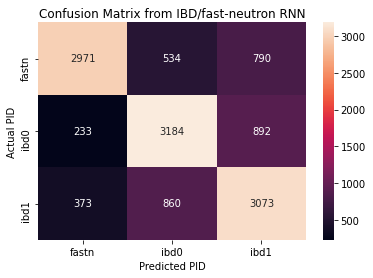

In [131]:
confmat = confusion_matrix(y_test_2, y_pred_2)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from IBD/fast-neutron RNN')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['fastn', 'ibd0', 'ibd1'])
ax.yaxis.set_ticklabels(['fastn', 'ibd0', 'ibd1'])

plt.show()

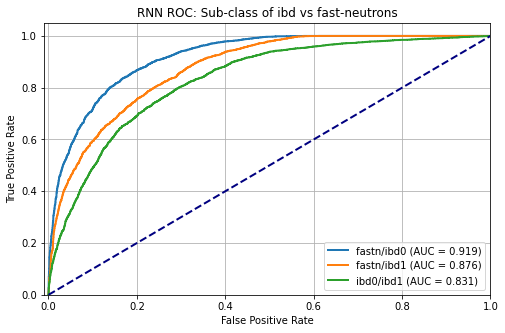

In [132]:
cat1 = [0, 0, 1]
cat2 = [1, 2, 2]
labels = ['fastn/ibd0', 'fastn/ibd1', 'ibd0/ibd1', 
         ]
plt.figure(figsize=(8,5))
for i, j, label in zip(cat1, cat2, 
                        labels,
                         ):
    mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
    prob = scores[:, j][mask]
    
    guesses = y_test_2[mask]
    guesses = guesses - np.min(guesses)
    guesses = guesses/np.max(guesses)

    fpr, tpr, thresholds = roc_curve(guesses, prob)
        
    auc = roc_auc_score(y_test_2[mask], prob)
    plt.plot(fpr, tpr, 
         label='%s (AUC = %0.3f)'%(label, auc), 
#          color='darkorange', 
         lw=2, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RNN ROC: Sub-class of ibd vs fast-neutrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [ ]:
ak.to

## Binary Model 

In [87]:
model1 = Sequential()
# create the model
model1.add(InputLayer(42))
model1.compile()

In [88]:
regressor2 = Sequential()
input_shape = X2.shape[1:]
regressor2.add(InputLayer(input_shape=input_shape))
regressor2.add(LSTM(units=256, 
                   return_sequences=True, 
                   dropout=0.2,
                  ))  

regressor2.add(LSTM(units=128, 
                   return_sequences=True, 
                   dropout=0.2, 
                   
                  ))
regressor2.add(LSTM(units=64, 
                   return_sequences=True, 
                   dropout=0.2, 
                   
                  ))

regressor2.add(LSTM(units=32, 
                   return_sequences=False, 
                   dropout=0.2, 
                   
                  ))

In [89]:
mergedOut = Concatenate()([model1.output, regressor2.output])

In [90]:
mergedOut = Flatten()(mergedOut)    
mergedOut = Dense(256, activation='relu')(mergedOut)
mergedOut = Dropout(.2)(mergedOut)
mergedOut = Dense(128, activation='relu')(mergedOut)
mergedOut = Dropout(.2)(mergedOut)
mergedOut = Dense(64, activation='relu')(mergedOut)
mergedOut = Dropout(.2)(mergedOut)
# output layer
mergedOut = Dense(1, activation='sigmoid')(mergedOut)


In [102]:
newModel2 = Model([model1.input, regressor2.input], mergedOut)
    #use lists if you want more than one input or output    
newModel2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
newModel2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 200, 6)]     0                                            
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 200, 256)     269312      input_7[0][0]                    
__________________________________________________________________________________________________
lstm_14 (LSTM)                  (None, 200, 128)     197120      lstm_13[0][0]                    
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 200, 64)      49408       lstm_14[0][0]                    
____________________________________________________________________________________________

Typically seems to go down then slowly back up.. maybe training on the dense part too fast and propagating all errors there? give it more time maybe? 

In [81]:
checkpoint_path = "training_2_cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [32]:
all_data = ak.concatenate([ibd, fastn])

In [33]:
fn = all_data['code']==2
invbeta = all_data['code']==1
id0 = all_data['subid']==0
id1p = all_data['subid']>0 # >0 changes things 

In [34]:
ibd0_mask = ak.from_iter([all(t) for t in zip(invbeta, id0)])
ibd1_mask = ak.from_iter([all(t) for t in zip(invbeta, id1p)])
fastn0_mask = ak.from_iter([all(t) for t in zip(fn, id0)])
fastn1_mask = ak.from_iter([all(t) for t in zip(fn, id1p)])

In [92]:
samples = min([ak.count_nonzero(fn), 
              ak.count_nonzero(invbeta)])

In [93]:
x1 = all_data[fn][:samples]
x1 = ak.concatenate((x1, all_data[invbeta][:samples]))

data_to_manipulate = [all_data[fn][:samples],
                     all_data[invbeta][:samples]
                     ]

In [94]:
# eplus = get_dims(positrons, dimensions=dimensions)[:samples]
X1 = get_dims(x1, dimensions=dimensions)
X1 = ak.to_pandas(X1)

Remaining variables selected for analysis: 42


In [95]:
X2, y = prep_net_data(data_to_manipulate, prompt=True, restime=True, maxlen=200)

Running set 1 of 2
Running set 2 of 2


In [119]:
# Split dataset into training set and test set
X_train1, X_test1, X_train2, X_test2, y_train, y_test = train_test_split(X1, X2, y, test_size=0.25, random_state=43) 

In [120]:
X_save = X_test1
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)

In [103]:
history = newModel2.fit([X_train1, X_train2], y_train,
                       validation_data=([X_test1, X_test2], y_test),
                       epochs=100, batch_size=64, 
                       callbacks=[cp_callback]
         )

Epoch 1/100
597/597 [==============================] - 601s 998ms/step - loss: 0.4497 - accuracy: 0.7735 - val_loss: 0.3801 - val_accuracy: 0.8139

Epoch 00001: saving model to training_1_cp.ckpt
Epoch 2/100
597/597 [==============================] - 595s 997ms/step - loss: 0.3832 - accuracy: 0.8135 - val_loss: 0.3721 - val_accuracy: 0.8167

Epoch 00002: saving model to training_1_cp.ckpt
Epoch 3/100
597/597 [==============================] - 597s 1s/step - loss: 0.3710 - accuracy: 0.8204 - val_loss: 0.3670 - val_accuracy: 0.8177

Epoch 00003: saving model to training_1_cp.ckpt
Epoch 4/100
597/597 [==============================] - 598s 1s/step - loss: 0.3649 - accuracy: 0.8232 - val_loss: 0.3641 - val_accuracy: 0.8211

Epoch 00004: saving model to training_1_cp.ckpt
Epoch 5/100
597/597 [==============================] - 597s 1s/step - loss: 0.3638 - accuracy: 0.8261 - val_loss: 0.3624 - val_accuracy: 0.8233

Epoch 00005: saving model to training_1_cp.ckpt
Epoch 6/100
597/597 [========

KeyboardInterrupt: 

In [104]:
plt.plot(history['val_loss'], 
         color='r', lw=2, label='Validation Loss', 
        )
plt.plot(history['loss'], 
         color='b', lw=2, label='Training Loss', 
        )

plt.plot(history['val_acc'], 
         color='r', lw=2, linestyle='--', 
         label='Validation Accuracy', 
        )
plt.plot(history['loss'], 
         color='b', lw=2, linestyle='--', 
         label='Training Accuracy', 
        )

NameError: name 'history' is not defined

In [112]:
scores = newModel2.predict([X_test1, X_test2])

In [113]:
y_pred_2 = np.round(scores)
y_test_2 = y_test

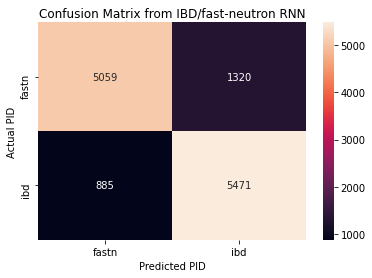

In [114]:
confmat = confusion_matrix(y_test_2, y_pred_2)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from IBD/fast-neutron RNN')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['fastn', 'ibd'])
ax.yaxis.set_ticklabels(['fastn', 'ibd'])

plt.show()

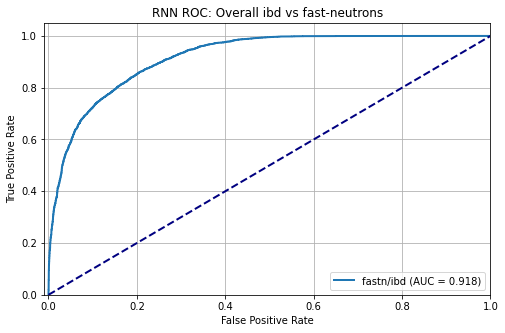

In [117]:
cat1 = [0]
cat2 = [1]
labels = ['fastn/ibd', 
         ]
plt.figure(figsize=(8,5))
for i, j, label in zip(cat1, cat2, 
                        labels,
                         ):
    mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
    prob = scores[mask]
    
    guesses = y_test_2[mask]
    guesses = guesses - np.min(guesses)
    guesses = guesses/np.max(guesses)

    fpr, tpr, thresholds = roc_curve(guesses, prob)
        
    auc = roc_auc_score(y_test_2[mask], prob)
    plt.plot(fpr, tpr, 
         label='%s (AUC = %0.3f)'%(label, auc), 
#          color='darkorange', 
         lw=2, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RNN ROC: Overall ibd vs fast-neutrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [131]:
wrong = X_save[y_pred_2!=y_test]

In [129]:
rightpred = y_test[y_pred_2!=y_test]

In [158]:
fastnwrong = fastn[wrong[rightpred==0].index.values]
ibdwrong = ibd[wrong[rightpred==1].index.values-samples]

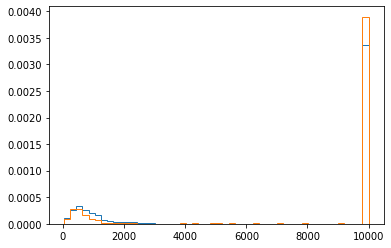

In [182]:
key = 'drPrevr'
kw = dict(histtype='step', density=True)
bins = plt.hist(fastnwrong[key], bins=50, **kw)
plt.hist(ibdwrong[key], bins=bins[1], **kw)
plt.show()